# Import Libraries

In [1]:
%run libs.ipy

# Reading Data

In [2]:
X_train, y_train = get_raw_data()

Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57639 entries, 0 to 59111
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   clanodo         57639 non-null  object        
 1   fecha           57639 non-null  datetime64[ns]
 2   fecha_h         57639 non-null  datetime64[ns]
 3   festivo         57639 non-null  int64         
 4   mes             57639 non-null  int64         
 5   diaSemana       57639 non-null  int64         
 6   hora            57639 non-null  int64         
 7   mda             57639 non-null  float64       
 8   mtr             57639 non-null  float64       
 9   mda7            57639 non-null  float64       
 10  mtr7            57639 non-null  float64       
 11  ypast7          57639 non-null  int64         
 12  festivo7        57639 non-null  int64         
 13  mda14           57639 non-null  float64       
 14  mtr14           57639 non-null  float64       
 15  yp

# PipeLine

In [4]:
imputer = ColumnTransformer([
    ('drop_features', 'drop', ['fecha','fecha_h','DART (MXN/MWh)','DARTbin','mda','mtr','ban','Year','Day','festivo','festivo7','festivo14','eolica','fotovol','hsc','ypast7','ypast14']),
    ('impute_mean', SimpleImputer(strategy='mean'), ['temperatura','demanda']),
], remainder='passthrough', verbose_feature_names_out=False)
encoder = ColumnTransformer([
    ('ord_enc', OrdinalEncoder(categories=[['06RAP-400', '06CED-230','03DEC-230']], handle_unknown='use_encoded_value', unknown_value=3), ['clanodo'])
    #('one_hot', OneHotEncoder(handle_unknown='ignore'), ['class of worker', 'education', 'sex'])
    #('one_hot2', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=["object_"]).columns.to_list()[9:13])
], remainder='passthrough', verbose_feature_names_out=False)
scalar = ColumnTransformer([
    ('robust', RobustScaler(), ['eolica', 'fotovol','diff'])
], remainder='passthrough', verbose_feature_names_out=False)

In [5]:

datapipe = Pipeline(steps=[
 
    ('imputer', imputer),
    ('df1', MatrixToDataFrame(imputer)),
    ('encoder', encoder),
    ('df2', MatrixToDataFrame(encoder))
    #('scalar', scalar),
    #('df3', MatrixToDataFrame(scalar))
])


In [6]:
X_tr = datapipe.fit_transform(X_train)

In [7]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57639 entries, 0 to 57638
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   clanodo      57639 non-null  float64
 1   temperatura  57639 non-null  float64
 2   demanda      57639 non-null  float64
 3   mes          57639 non-null  float64
 4   diaSemana    57639 non-null  float64
 5   hora         57639 non-null  float64
 6   mda7         57639 non-null  float64
 7   mtr7         57639 non-null  float64
 8   mda14        57639 non-null  float64
 9   mtr14        57639 non-null  float64
 10  ypast3avg    57639 non-null  float64
 11  diff         57639 non-null  float64
dtypes: float64(12)
memory usage: 5.3 MB


# Creating Data Frame for a node

In [8]:
node=0
DF_node=X_tr[X_tr['clanodo']==node];X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57639 entries, 0 to 57638
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   clanodo      57639 non-null  float64
 1   temperatura  57639 non-null  float64
 2   demanda      57639 non-null  float64
 3   mes          57639 non-null  float64
 4   diaSemana    57639 non-null  float64
 5   hora         57639 non-null  float64
 6   mda7         57639 non-null  float64
 7   mtr7         57639 non-null  float64
 8   mda14        57639 non-null  float64
 9   mtr14        57639 non-null  float64
 10  ypast3avg    57639 non-null  float64
 11  diff         57639 non-null  float64
dtypes: float64(12)
memory usage: 5.3 MB


# Visualizing DART

<Figure size 432x288 with 1 Axes>

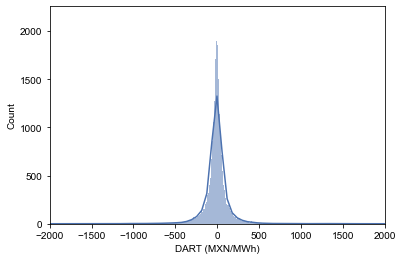

In [9]:
fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(16, 8)})
sns.histplot(data=X_train, x='DART (MXN/MWh)', kde=True)
ax.set_xlim(-2000, 2000)
plt.show()

# The data is balanced

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 576x288 with 1 Axes>

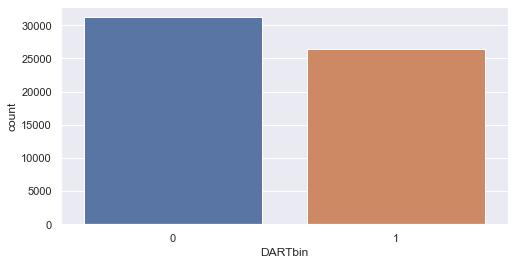

In [10]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.countplot(X_train['DARTbin'])
plt.show()

# Creating Train and Test Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_train, test_size=0.33)

# Dummy Model

In [12]:
dc = DummyClassifier(strategy='uniform').fit(X_train, y_train)
yhat_dc = dc.predict(X_test)
accuracy_score(y_test, yhat_dc), precision_score(y_test, yhat_dc), recall_score(y_test, yhat_dc)

(0.5001314336785658, 0.45674594822142706, 0.49965461662445315)

# Default Models

In [13]:
candidates = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier]
accuracies = np.zeros(len(candidates))
precision = np.zeros(len(candidates))
recall = np.zeros(len(candidates))
for i, Model in enumerate(candidates):
    model = Model().fit(X_train, y_train)
    yhat = model.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    prec = precision_score(y_test, yhat)
    rec = recall_score(y_test, yhat)
    accuracies[i] = acc
    precision[i] = prec
    recall[i] = rec
for i, c in enumerate(candidates):
    print(c.__name__,"acc: ",accuracies[i])
    print(c.__name__,"prec: ",precision[i])
    print(c.__name__,"recc: ",recall[i])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LogisticRegression acc:  0.5841438410178224
LogisticRegression prec:  0.5711143695014663
LogisticRegression recc:  0.3587381994013355
DecisionTreeClassifier acc:  0.773040323852584
DecisionTreeClassifier prec:  0.7512363427257044
DecisionTreeClassifier recc:  0.7520147363573567
RandomForestClassifier acc:  0.8601545660059934
RandomForestClassifier prec:  0.8727115289460663
RandomForestClassifier recc:  0.8122265714943587
XGBClassifier acc:  0.7306661058829714
XGBClassifier prec:  0.7312134977287476
XGBClassifier recc:  0.6486299792769975


<Figure size 576x288 with 1 Axes>

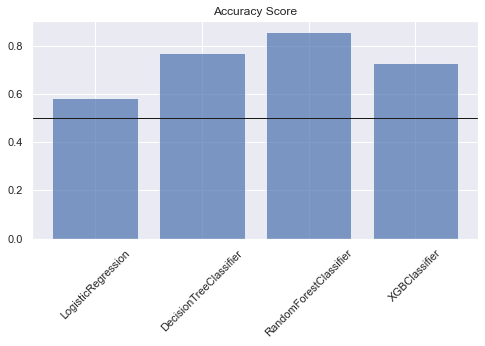

In [14]:
plt.bar([c.__name__ for c in candidates], accuracies, alpha=0.7)
plt.xticks(rotation=45)
plt.axhline(y=0.5001, linewidth=1, color='k')
plt.title("Accuracy Score");

Text(0.5, 1.0, 'Precision Score')

<Figure size 576x288 with 1 Axes>

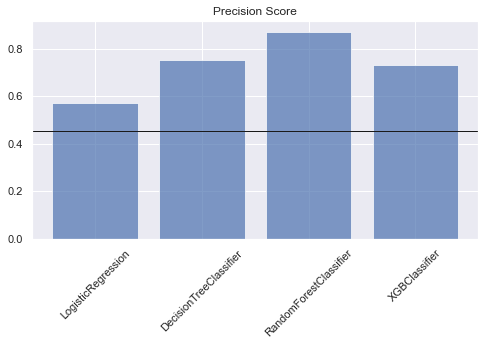

In [15]:
plt.bar([c.__name__ for c in candidates], precision,  alpha=0.7)
plt.xticks(rotation=45)
plt.axhline(y=0.4556, linewidth=1, color='k')
plt.title("Precision Score")

Text(0.5, 1.0, 'Recall Score')

<Figure size 576x288 with 1 Axes>

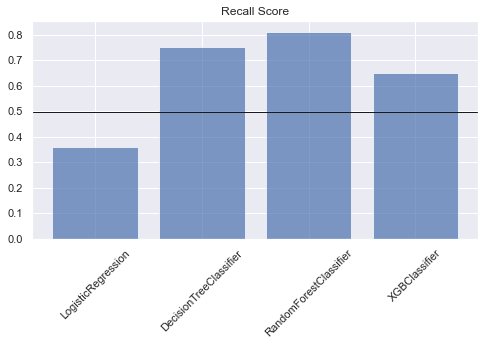

In [16]:
plt.bar([c.__name__ for c in candidates], recall, alpha=0.7)
plt.xticks(rotation=45)
plt.axhline(y=0.4972, linewidth=1, color='k')
plt.title("Recall Score")

# GridSearch XGBoost

In [17]:
parameters = {
    'max_depth': range (2, 32, 4),
    'n_estimators': [5,15,50],
    'learning_rate': [0.3, 0.01]
}
model = XGBClassifier(use_label_encoder =False)
gs = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=1, scoring = 'f1')
gs.fit(X_train, y_train)
gs.best_score_, gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[12:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.8156993934549297, {'learning_rate': 0.3, 'max_depth': 30, 'n_estimators': 50})

# Final XGBoost Model

In [18]:
finalmodel = XGBClassifier(learning_rate = 0.3, max_depth = 30 , n_estimators = 50)
finalmodel.fit(X_train, y_train)
y_hat = finalmodel.predict(X_test)
f1_score(y_test, y_hat)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.837842617152962

In [19]:
 accuracy_score(y_test, y_hat),precision_score(y_test, y_hat),recall_score(y_test, y_hat)

(0.8553703801061984, 0.8584370093006402, 0.8182132166705043)

# Confusion matrixPrecision 

<Figure size 576x288 with 2 Axes>

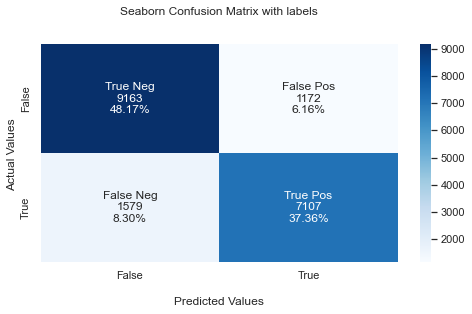

In [20]:
#plot_confusion_matrix(finalmodel,X_test,y_test)
cf_matrix = confusion_matrix(y_test, y_hat)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 576x288 with 1 Axes>

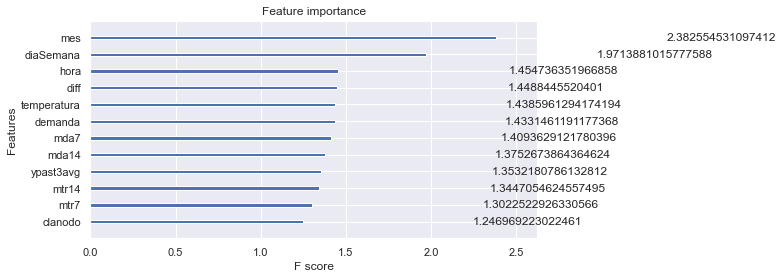

In [21]:
xgb.plot_importance(finalmodel,importance_type='gain')

# Exporting XGBoost final model

In [22]:
import pickle
with open('model.p', 'wb') as f:
    pickle.dump(finalmodel, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    

In [24]:
with open('model.p', 'rb') as f:
    reanimated = pickle.load(f)

In [25]:

reanimated.score(X_test, y_test)



0.8553703801061984

# Creating CSV Input

Para que el input tenga las mismas características que el X_test

In [392]:
X_input = pd.read_csv('Input.csv');X_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   clanodo      933 non-null    object 
 1   temperatura  933 non-null    int64  
 2   demanda      933 non-null    float64
 3   mes          933 non-null    int64  
 4   diaSemana    933 non-null    int64  
 5   hora         933 non-null    int64  
 6   mda7         933 non-null    float64
 7   mtr7         933 non-null    float64
 8   ypast7       933 non-null    int64  
 9   mda14        933 non-null    float64
 10  mtr14        933 non-null    float64
 11  ypast14      933 non-null    int64  
 12  ypast3avg    933 non-null    float64
 13  diff         933 non-null    float64
 14  hsc          933 non-null    float64
 15  fecha        933 non-null    object 
dtypes: float64(8), int64(6), object(2)
memory usage: 116.8+ KB


In [393]:
X_input['clanodo']= X_input['clanodo'].replace("06RAP-400", 0)
X_input['clanodo']= X_input['clanodo'].replace("06CED-230", 1)
X_input['clanodo']= X_input['clanodo'].replace("03DEC-230", 2);X_input.head()

,clanodo,temperatura,demanda,mes,diaSemana,hora,mda7,mtr7,ypast7,mda14,mtr14,ypast14,ypast3avg,diff,hsc,fecha
0,2,12,595.056,4,5,1,889.50,878.82,0,1019.74,1545.47,1,0.666667,-1.696666,5.32,01/04/2022
1,2,12,585.359,4,5,2,894.91,889.17,0,1040.31,1052.58,1,0.666667,5.903333,5.32,01/04/2022
2,2,13,597.930,4,5,3,884.91,884.73,0,1024.43,979.80,0,0.333333,-13.450000,5.32,01/04/2022
3,2,16,564.534,4,5,4,880.69,878.93,0,1019.32,955.95,0,0.333333,-23.560000,5.32,01/04/2022
4,2,20,584.008,4,5,5,881.77,889.68,1,1032.36,955.25,0,0.000000,-30.190000,5.32,01/04/2022


In [394]:
X_input = X_input.drop(['hsc','ypast7','ypast14','fecha'], axis=1);X_input.head()

,clanodo,temperatura,demanda,mes,diaSemana,hora,mda7,mtr7,mda14,mtr14,ypast3avg,diff
0,2,12,595.056,4,5,1,889.50,878.82,1019.74,1545.47,0.666667,-1.696666
1,2,12,585.359,4,5,2,894.91,889.17,1040.31,1052.58,0.666667,5.903333
2,2,13,597.930,4,5,3,884.91,884.73,1024.43,979.80,0.333333,-13.450000
3,2,16,564.534,4,5,4,880.69,878.93,1019.32,955.95,0.333333,-23.560000
4,2,20,584.008,4,5,5,881.77,889.68,1032.36,955.25,0.000000,-30.190000


In [348]:
X_test.columns

Index(['clanodo', 'temperatura', 'demanda', 'mes', 'diaSemana', 'hora', 'mda7',
       'mtr7', 'mda14', 'mtr14', 'ypast3avg', 'diff'],
      dtype='object')

In [395]:
y_pred = finalmodel.predict(X_input);y_pred 

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [396]:
y_prob =pd.DataFrame(finalmodel.predict_proba(X_input)[:,1]);y_prob

,0
0,0.617874
1,0.731671
2,0.148080
3,0.462791
4,0.521040
...,...
928,0.847757
929,0.854906
930,0.853800
931,0.800406


# Exporting CSV Output

In [397]:
DF_output=pd.read_csv('Input.csv');DF_output.head()
DF_output['Forecast DART']=y_pred;DF_output 
DF_output['Probability mtr > mda']=y_prob;DF_output 
DF_output['Probability mda > mtr']=1-y_prob;DF_output 
DF_output_final = DF_output[['fecha','clanodo','hora','Forecast DART','Probability mda > mtr','Probability mtr > mda']];DF_output_final.head()


,clanodo,hora,Forecast DART,Probability mda > mtr,Probability mtr > mda
0,03DEC-230,1,1,0.382126,0.617874
1,03DEC-230,2,1,0.268329,0.731671
2,03DEC-230,3,0,0.851920,0.148080
3,03DEC-230,4,0,0.537209,0.462791
4,03DEC-230,5,1,0.478960,0.521040


In [398]:
DF_output_final.to_csv('Output_clean_from_Notebook.csv',index=False)

## Comparing results

In [399]:
y_actual = pd.read_csv('Output_actual.csv');y_actual.head()

,clanodo,temperatura,demanda,mes,diaSemana,hora,mda7,mtr7,ypast7,mda14,mtr14,ypast14,ypast3avg,diff,hsc,fecha,ban
0,03DEC-230,12,595.056,4,5,1,889.50,878.82,0,1019.74,1545.47,1,0.666667,-1.696666,5.32,01/04/2022,0
1,03DEC-230,12,585.359,4,5,2,894.91,889.17,0,1040.31,1052.58,1,0.666667,5.903333,5.32,01/04/2022,0
2,03DEC-230,13,597.930,4,5,3,884.91,884.73,0,1024.43,979.80,0,0.333333,-13.450000,5.32,01/04/2022,0
3,03DEC-230,16,564.534,4,5,4,880.69,878.93,0,1019.32,955.95,0,0.333333,-23.560000,5.32,01/04/2022,0
4,03DEC-230,20,584.008,4,5,5,881.77,889.68,1,1032.36,955.25,0,0.000000,-30.190000,5.32,01/04/2022,0


In [400]:
y_actual=y_actual['ban'];y_actual

0      0
1      0
2      0
3      0
4      0
      ..
928    0
929    0
930    0
931    0
932    0
Name: ban, Length: 933, dtype: int64

In [402]:
 accuracy_score(y_actual, y_pred),precision_score(y_actual, y_pred),recall_score(y_actual, y_pred)

(0.5380493033226152, 0.32096069868995636, 0.550561797752809)

## Thresold analysis

In [403]:
y_pred_new=pd.DataFrame( (finalmodel.predict_proba(X_input)[:,1] >= 0.5).astype(bool))
y_pred_new[0]=y_pred_new[0].map({True:1,False:0})

In [405]:
 accuracy_score(y_actual, y_pred_new),precision_score(y_actual, y_pred_new),recall_score(y_actual, y_pred_new)

(0.5380493033226152, 0.32096069868995636, 0.550561797752809)

Lo anterior tenemos que hacerlo a través del entorno/dashboard. Por esta razón, exporto un csv de Inputs que ya está limpio. Este csv se va a leer desde el programa.exe para realizar los pronósticos sin necesidad del notebook.

# Exporting CSV Input 

In [406]:
X_input.to_csv('Input_clean.csv',index=False);X_input.head()

,clanodo,temperatura,demanda,mes,diaSemana,hora,mda7,mtr7,mda14,mtr14,ypast3avg,diff
0,2,12,595.056,4,5,1,889.50,878.82,1019.74,1545.47,0.666667,-1.696666
1,2,12,585.359,4,5,2,894.91,889.17,1040.31,1052.58,0.666667,5.903333
2,2,13,597.930,4,5,3,884.91,884.73,1024.43,979.80,0.333333,-13.450000
3,2,16,564.534,4,5,4,880.69,878.93,1019.32,955.95,0.333333,-23.560000
4,2,20,584.008,4,5,5,881.77,889.68,1032.36,955.25,0.000000,-30.190000
